In [17]:
# Импорт библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
import plotly.express as px
from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter

# Чтение JSON файла
with open('vacancies_data_with_salary.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    
# Нормализация данных
vacancies = pd.json_normalize(data)
df = vacancies.copy()

In [18]:
df.head(5)

,id,name,area,published_at,schedule,professional_roles,experience,employment,key_skills,salary.from,salary.to,salary.currency,salary.gross
0,112620411,Главный бухгалтер,Москва,2024-12-05T16:19:49+0300,Полный день,[Бухгалтер],От 3 до 6 лет,Полная занятость,"[Бухгалтерская отчетность, Финансовая отчетность]",350000.0,500000.0,RUR,False
1,112595285,React-разработчик,Минск,2024-12-05T13:04:08+0300,Удаленная работа,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[React, React Native, CSS, HTML, HTML5, Node.j...",600.0,950.0,USD,False
2,112214994,Frontend-разработчик,Алматы,2024-11-30T09:52:47+0300,Полный день,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[JavaScript, HTML, CSS, VueJS, TypeScript, RES...",150000.0,200000.0,KZT,True
3,112543205,Backend разработчик (Java),Алматы,2024-12-04T17:40:31+0300,Полный день,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[Java, Spring Framework, SQL, NoSQL, Git, CI/C...",1000000.0,NaN,KZT,True
4,112524085,Стажер/frontend разработчик,Минск,2024-12-04T14:47:08+0300,Полный день,"[Программист, разработчик]",Нет опыта,Полная занятость,[],NaN,200.0,USD,False


In [19]:
# Обработка пропусков
df.isnull().sum()
df = df.drop([ 'salary.gross'], axis=1)

# Переменование колонок
df = df.rename(columns={'salary.from':'salary_from',
                        'salary.to':'salary_to',
                        'salary.currency':'salary_currency',
                        'salary.gross': 'salary_gross'})

# Обработка ЗП и создание нового столбца 'salary'
df[['salary_from', 'salary_to']] = df[['salary_from', 'salary_to']].fillna(0)
def calculate_salary(row):
    if row['salary_from'] != 0 and row['salary_to'] != 0:
        return (row['salary_from'] + row['salary_to']) / 2
    else:
        return row['salary_from'] + row['salary_to']
df['salary'] = df.apply(calculate_salary, axis=1)

# Обработка даты публикации
df['published_date'] = pd.to_datetime(df['published_at']).dt.strftime('%Y/%m/%d')

# Обработка профессии
df['job'] = df['professional_roles'].apply(lambda x: ', '.join(x))
it_positions = ['Разработчик', 'Аналитик', 'Инженер', 'Data', 'Developer', 'Системный администратор', 'Тестировщик', 'UI/UX дизайнер', 'DevOps', 'Machine Learning Engineer', 'Программист', 'Дата', 'Другое']
df = df[df['job'].str.contains('|'.join(it_positions), regex=True)]
df = df.drop(['published_at', 'professional_roles', 'salary_from', 'salary_to'], axis=1)

# Перевод ЗП в рубли (курс взят на момент публикации JSON файла)
currency_rates = {
    'USD': 94.5,    
    'KZT': 0.2,     
    'BYR': 32,   
    'UZS': 0.0078,  
    'EUR': 103.2,   
    'KGS': 1.08,    
    'AZN': 55.0     
}
df['salary_rub'] = df.apply(
    lambda row: row['salary'] * currency_rates.get(row['salary_currency'], 1) if row['salary_currency'] in currency_rates else row['salary'], 
    axis=1
)

# Обработка навыков
df["key_skills"] = df["key_skills"].apply(lambda x: ",".join(x) if x else 'Всему научим')
df = df.drop('salary', axis=1)
df = df.drop(['salary_currency', 'id'], axis=1)

# Преобразование типов
df['salary_rub'] = df['salary_rub'].astype(int)
df['published_date'] = pd.to_datetime(df['published_date'])

In [28]:
df.head(5)

,name,area,schedule,experience,employment,key_skills,published_date,job,salary_rub
1,React-разработчик,Минск,Удаленная работа,От 1 года до 3 лет,Полная занятость,"React,React Native,CSS,HTML,HTML5,Node.js,JSON",2024-12-05,"Программист, разработчик",73237
2,Frontend-разработчик,Алматы,Полный день,От 1 года до 3 лет,Полная занятость,"JavaScript,HTML,CSS,VueJS,TypeScript,REST API,ES6",2024-11-30,"Программист, разработчик",35000
3,Backend разработчик (Java),Алматы,Полный день,От 1 года до 3 лет,Полная занятость,"Java,Spring Framework,SQL,NoSQL,Git,CI/CD,Dock...",2024-12-04,"Программист, разработчик",200000
4,Стажер/frontend разработчик,Минск,Полный день,Нет опыта,Полная занятость,Всему научим,2024-12-04,"Программист, разработчик",18900
5,Junior Frontend-разработчик,Санкт-Петербург,Удаленная работа,Нет опыта,Полная занятость,"JavaScript,REST API,Git,TypeScript,React Nativ...",2024-12-04,"Программист, разработчик",125000


In [25]:
def plot_percent(df, column_name, title, xlabel, flip_axes=False):
    # Получаем топ-10 значений по заданной колонке
    top_10 = (
        df[column_name]
        .value_counts(normalize=True)
        .multiply(100)
        .round(2)
        .head(10)
        .reset_index(name='percent')
    )
    # Столбец с категориями остается под названием "index"
    top_10.rename(columns={'index': column_name}, inplace=True)

    # Установка стилевой темы
    sns.set_theme(style="whitegrid", palette="muted")

    # Определяем размеры графика
    figsize = (12, 6) if not flip_axes else (10, 8)
    plt.figure(figsize=figsize, dpi=150)

    # Построение графика
    barplot_args = {'data': top_10, 'palette': 'coolwarm'}
    if flip_axes:
        sns.barplot(x='percent', y=column_name, **barplot_args)
        plt.xlabel('Процент, %', fontsize=12)
        plt.ylabel(xlabel, fontsize=12)
    else:
        sns.barplot(x=column_name, y='percent', **barplot_args)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel('Процент, %', fontsize=12)
        plt.xticks(rotation=45, ha='right')

    # Заголовок графика
    plt.title(title, fontsize=16, weight='bold', pad=15)

    # Добавляем проценты на столбцы
    for index, row in top_10.iterrows():
        if flip_axes:
            plt.text(row['percent'] + 1, index, f"{row['percent']}%", va='center', fontsize=10)
        else:
            plt.text(index, row['percent'] + 1, f"{row['percent']}%", ha='center', fontsize=10)

    # Убираем лишние рамки для более чистого вида
    sns.despine()

    plt.tight_layout()
    plt.show()

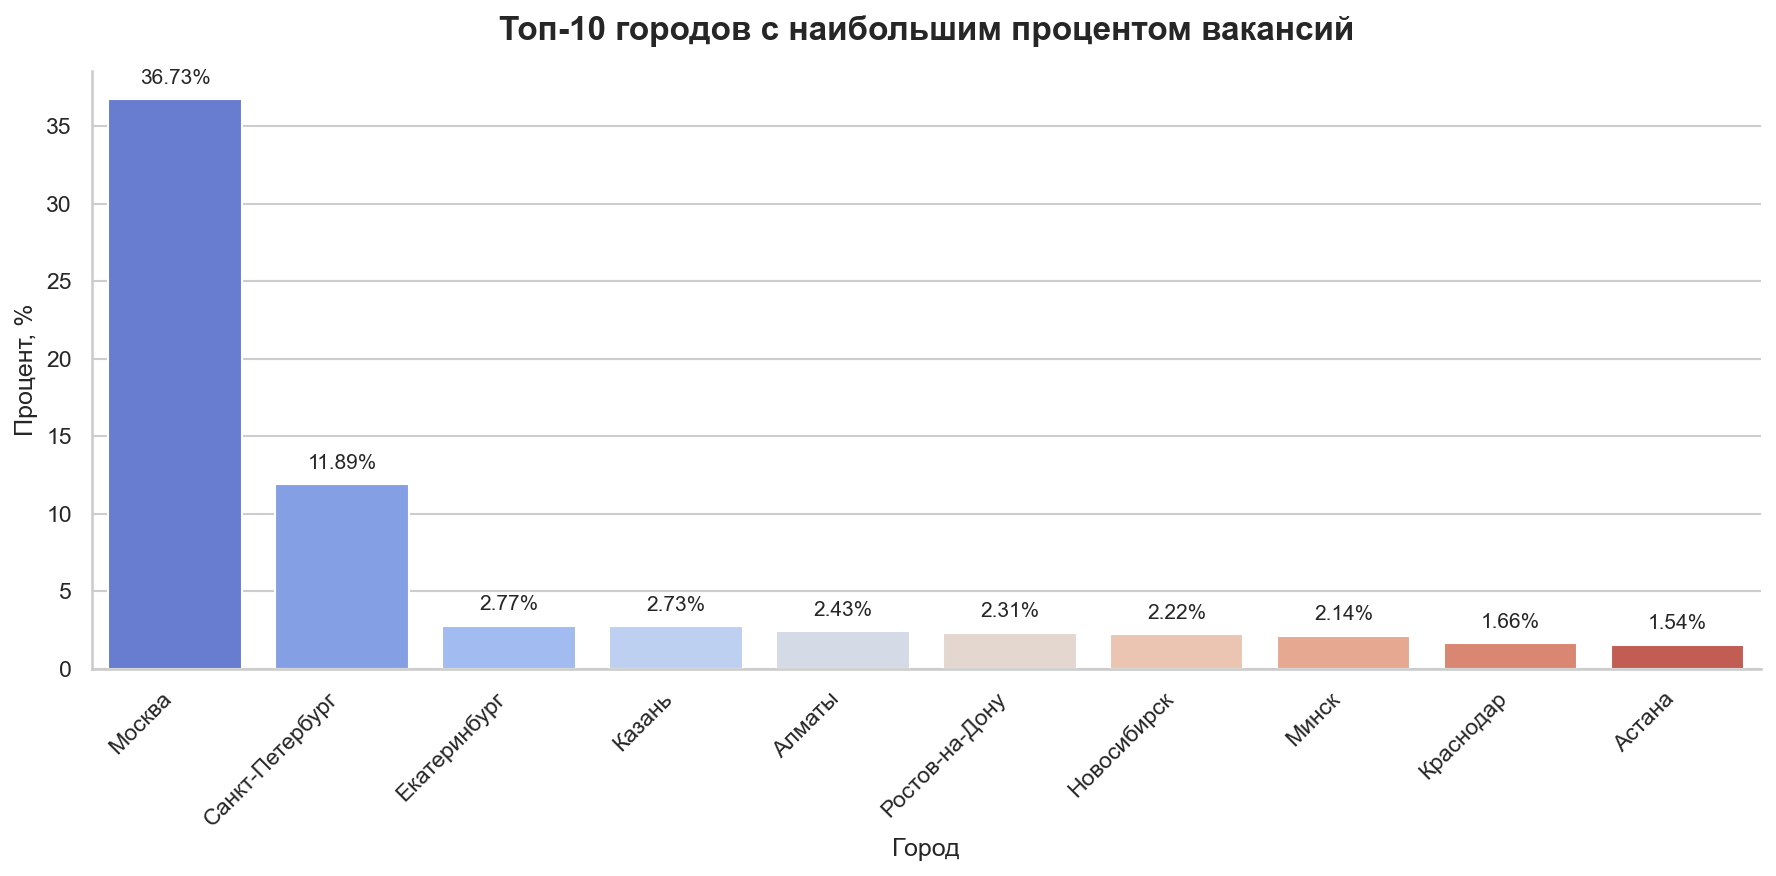

In [29]:
analysis_df = df.copy()
analysis_df
# Топ городов по вакансиям
plot_percent(analysis_df, 'area', 'Топ-10 городов с наибольшим процентом вакансий', 'Город');

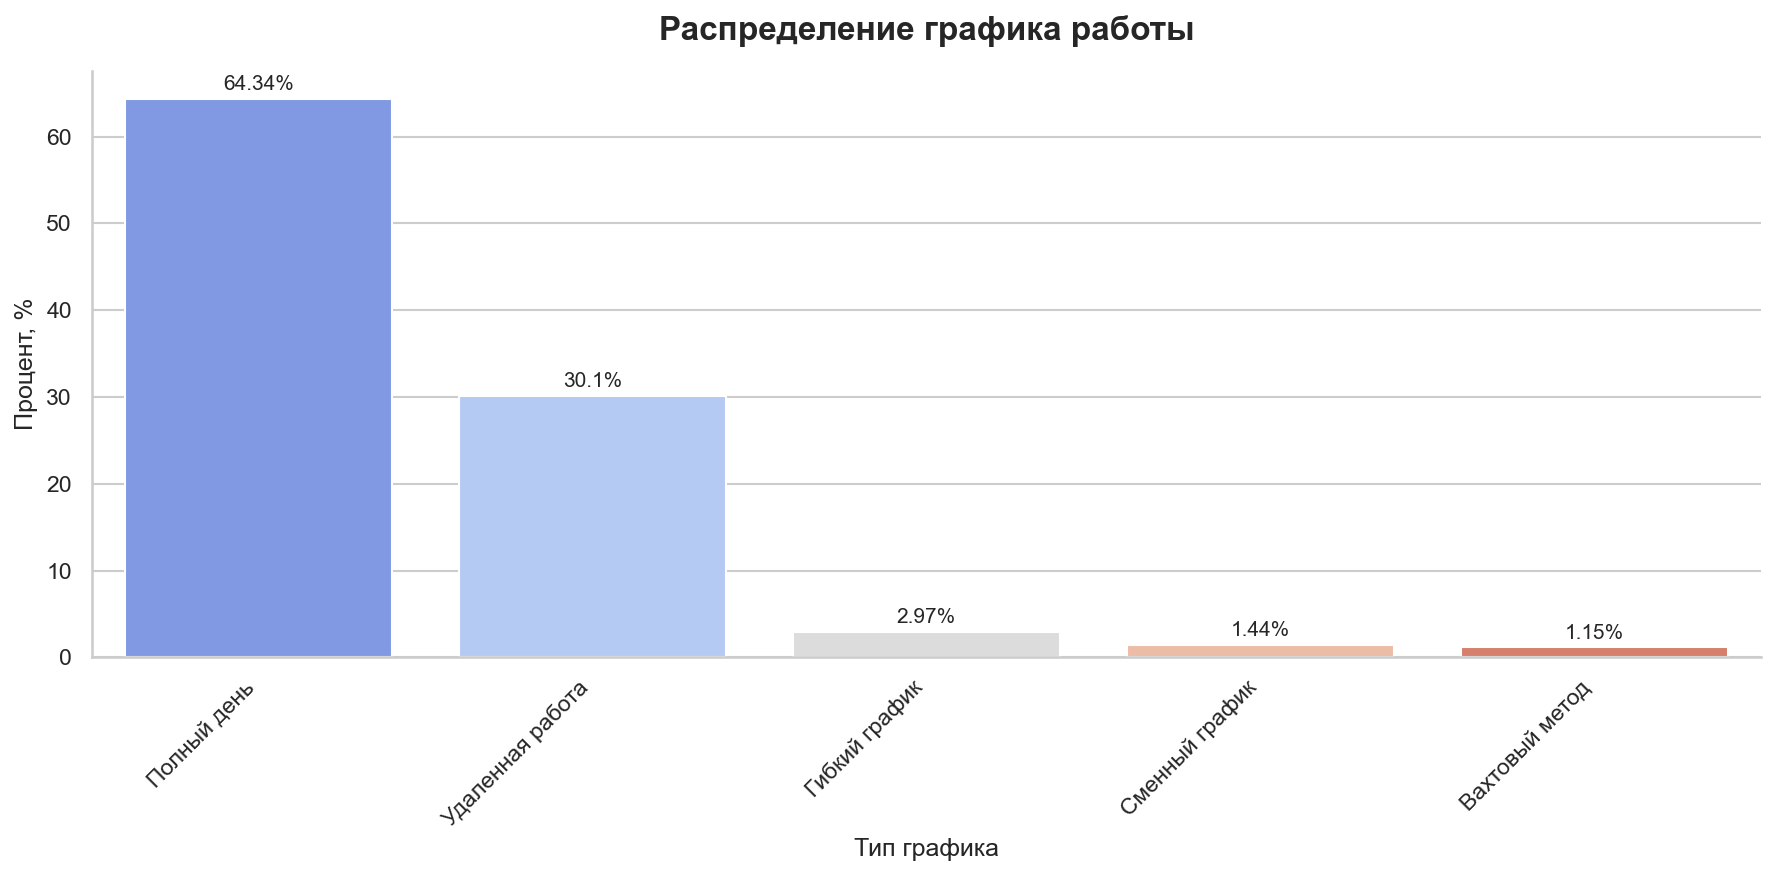

In [32]:
# Распределение графика работы
plot_percent(analysis_df, 'schedule', 'Распределение графика работы', xlabel='Тип графика')

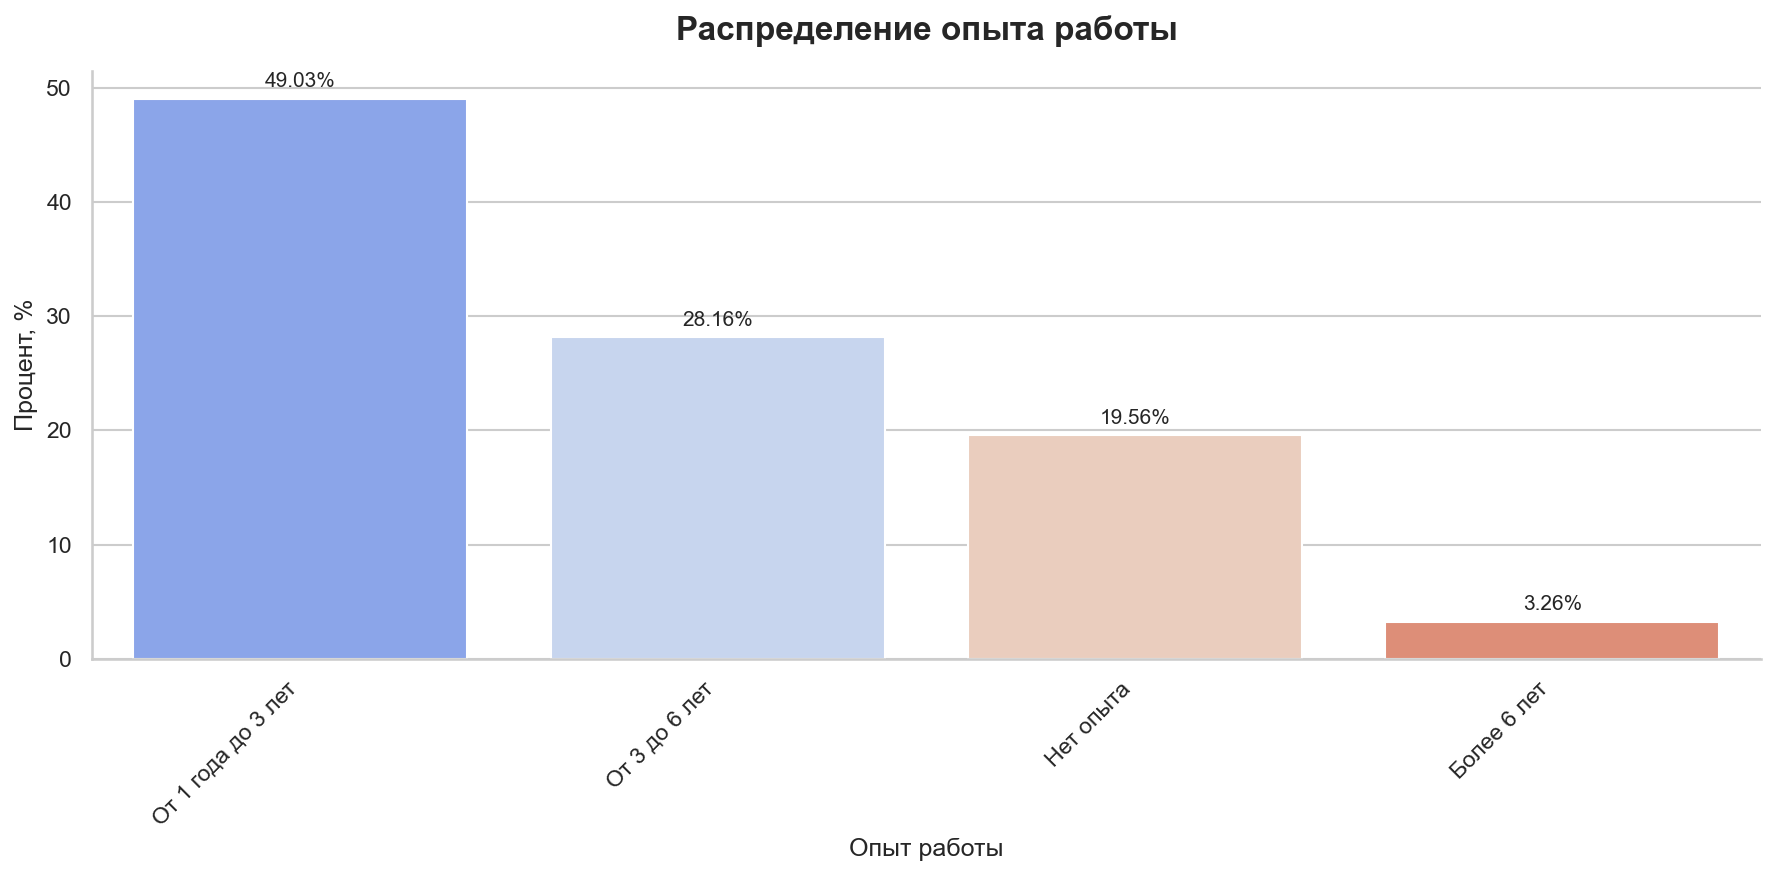

In [33]:
# Распределение опыта работы
plot_percent(analysis_df, 'experience', title='Распределение опыта работы', xlabel='Опыт работы')

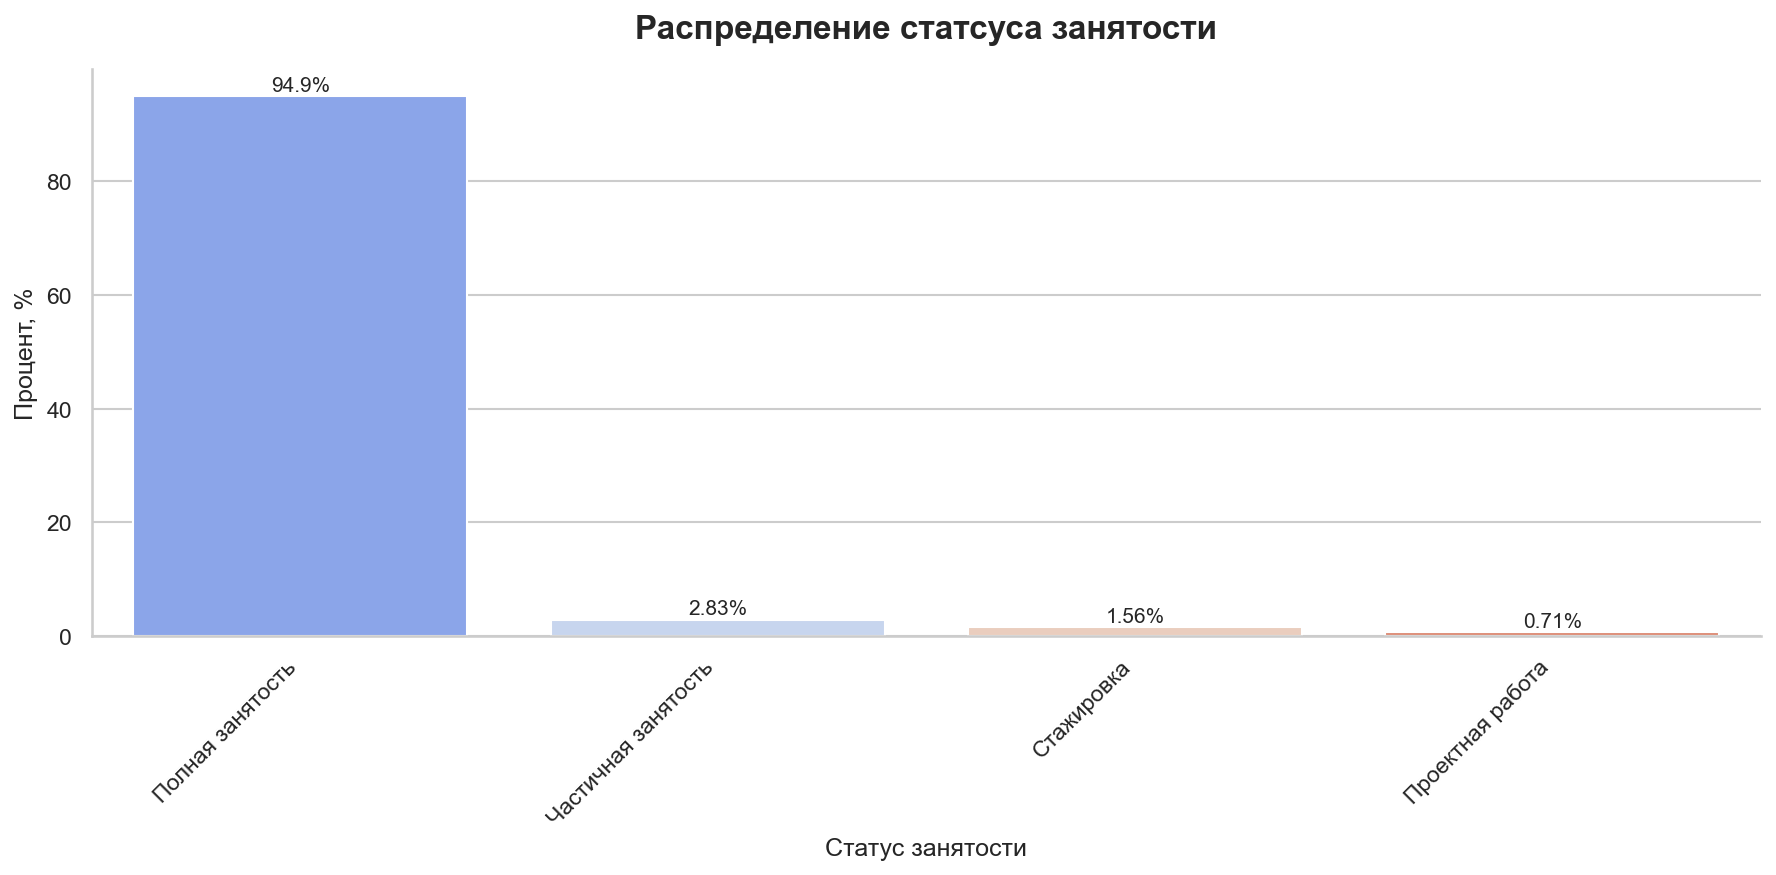

In [34]:
# Распределение статсуса занятости
plot_percent(analysis_df, 'employment', 'Распределение статсуса занятости', 'Cтатус занятости')

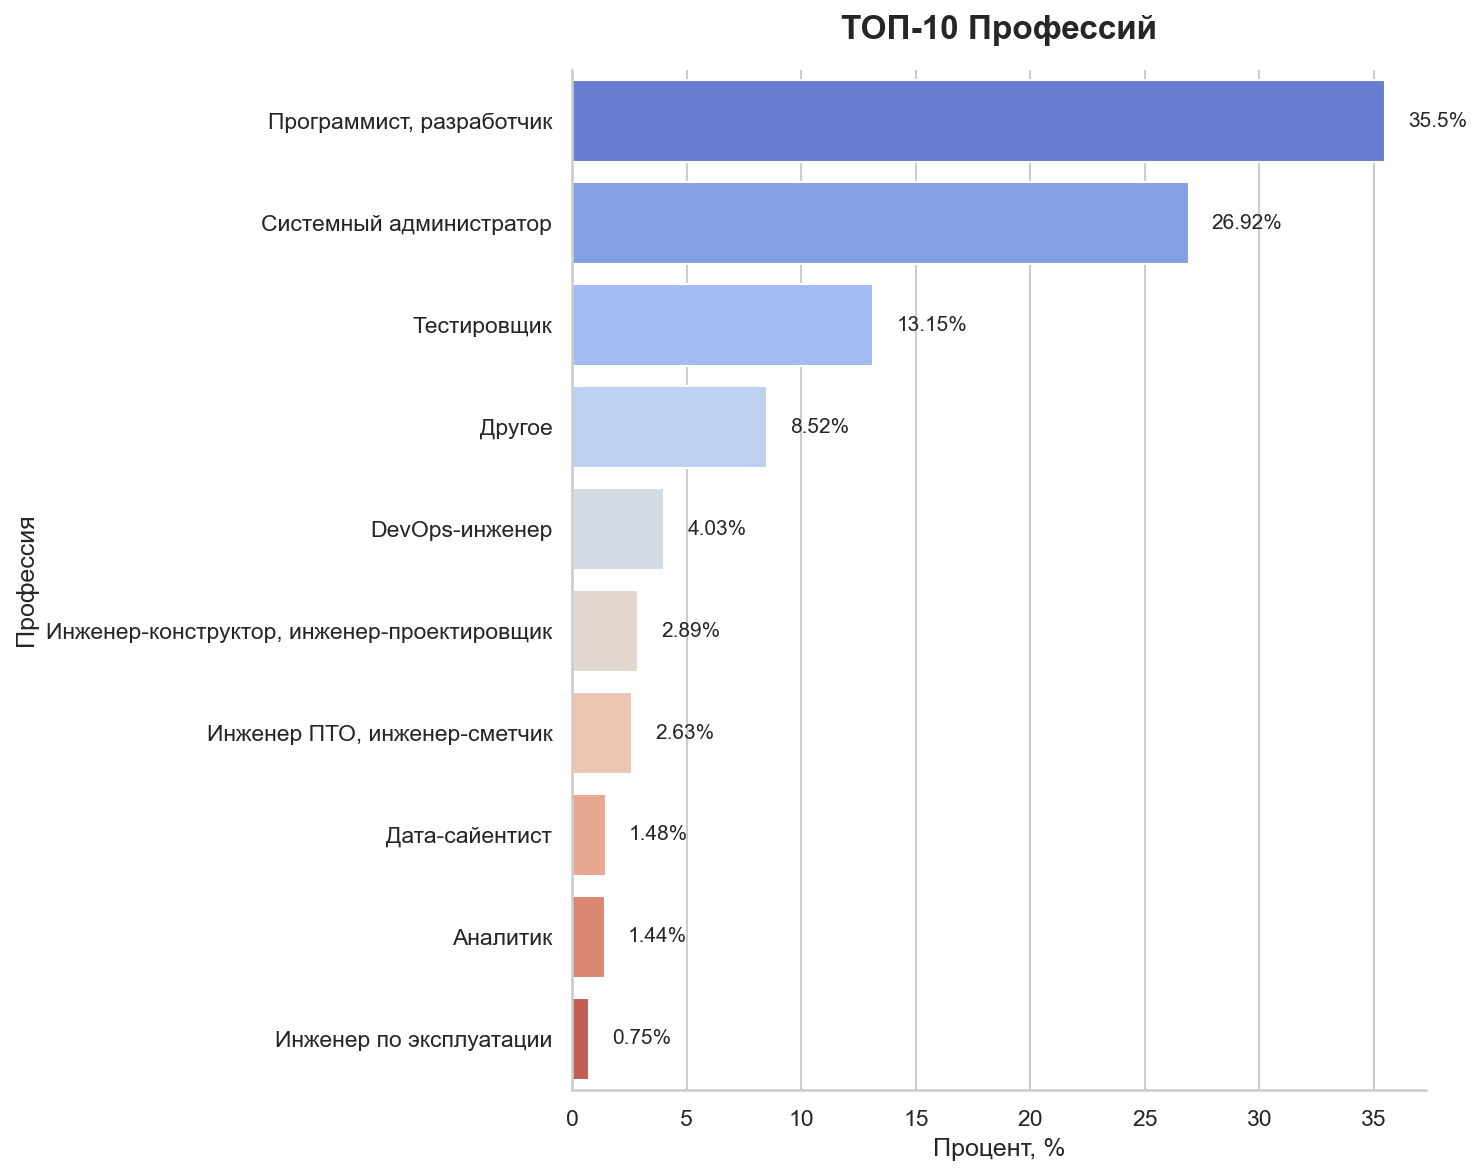

In [36]:
# ТОП-10 Профессий
plot_percent(analysis_df, 'job', 'ТОП-10 Профессий', 'Профессия', True)

Размер данных до обработки: 4944
Размер данных после обработки: 4698


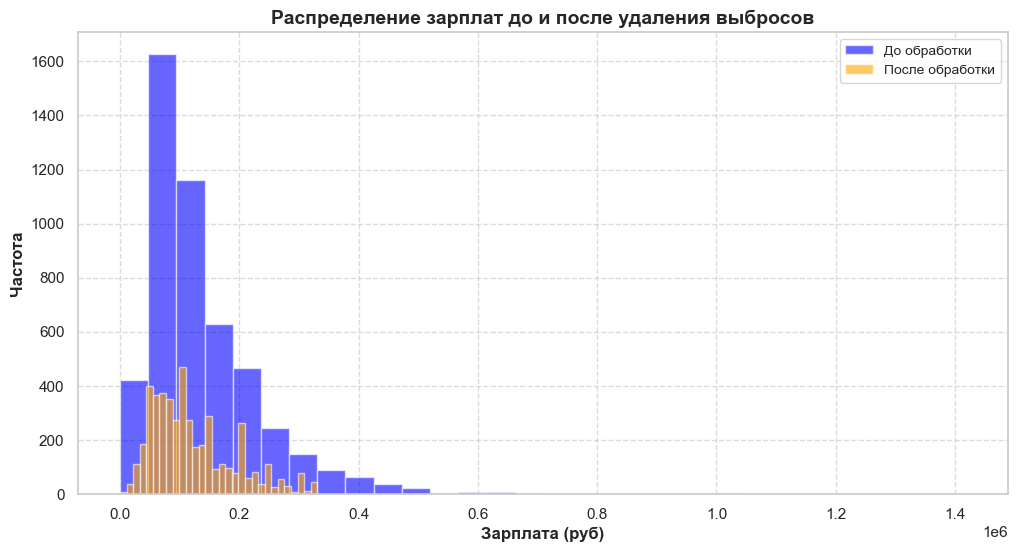

In [37]:
# Рассмотрим распределение по зарплате (до и после удаления выбросов)

# Рассчитываем IQR (межквартильный размах)
Q1 = analysis_df['salary_rub'].quantile(0.25)  # первый квартиль
Q3 = analysis_df['salary_rub'].quantile(0.75)  # третий квартиль
IQR = Q3 - Q1  # межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
filtered_data = analysis_df[(analysis_df['salary_rub'] >= lower_bound) & (analysis_df['salary_rub'] <= upper_bound)]

# Сравнение до и после
print(f"Размер данных до обработки: {analysis_df.shape[0]}")
print(f"Размер данных после обработки: {filtered_data.shape[0]}")

plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
plt.hist(analysis_df['salary_rub'], bins=30, alpha=0.6, color='blue', label='До обработки')  # Добавим цвет для до обработки
plt.hist(filtered_data['salary_rub'], bins=30, alpha=0.6, color='orange', label='После обработки')  # Добавим цвет для после обработки
plt.title('Распределение зарплат до и после удаления выбросов', fontsize=14, weight='bold')  # Увеличим шрифт заголовка
plt.xlabel('Зарплата (руб)', fontsize=12, weight='bold')  # Увеличим шрифт осей
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=10)  # Позиция легенды и размер шрифта
plt.grid(True, linestyle='--', alpha=0.7)  # Добавим сетку с изменёнными параметрами
plt.show()

D:\programs\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


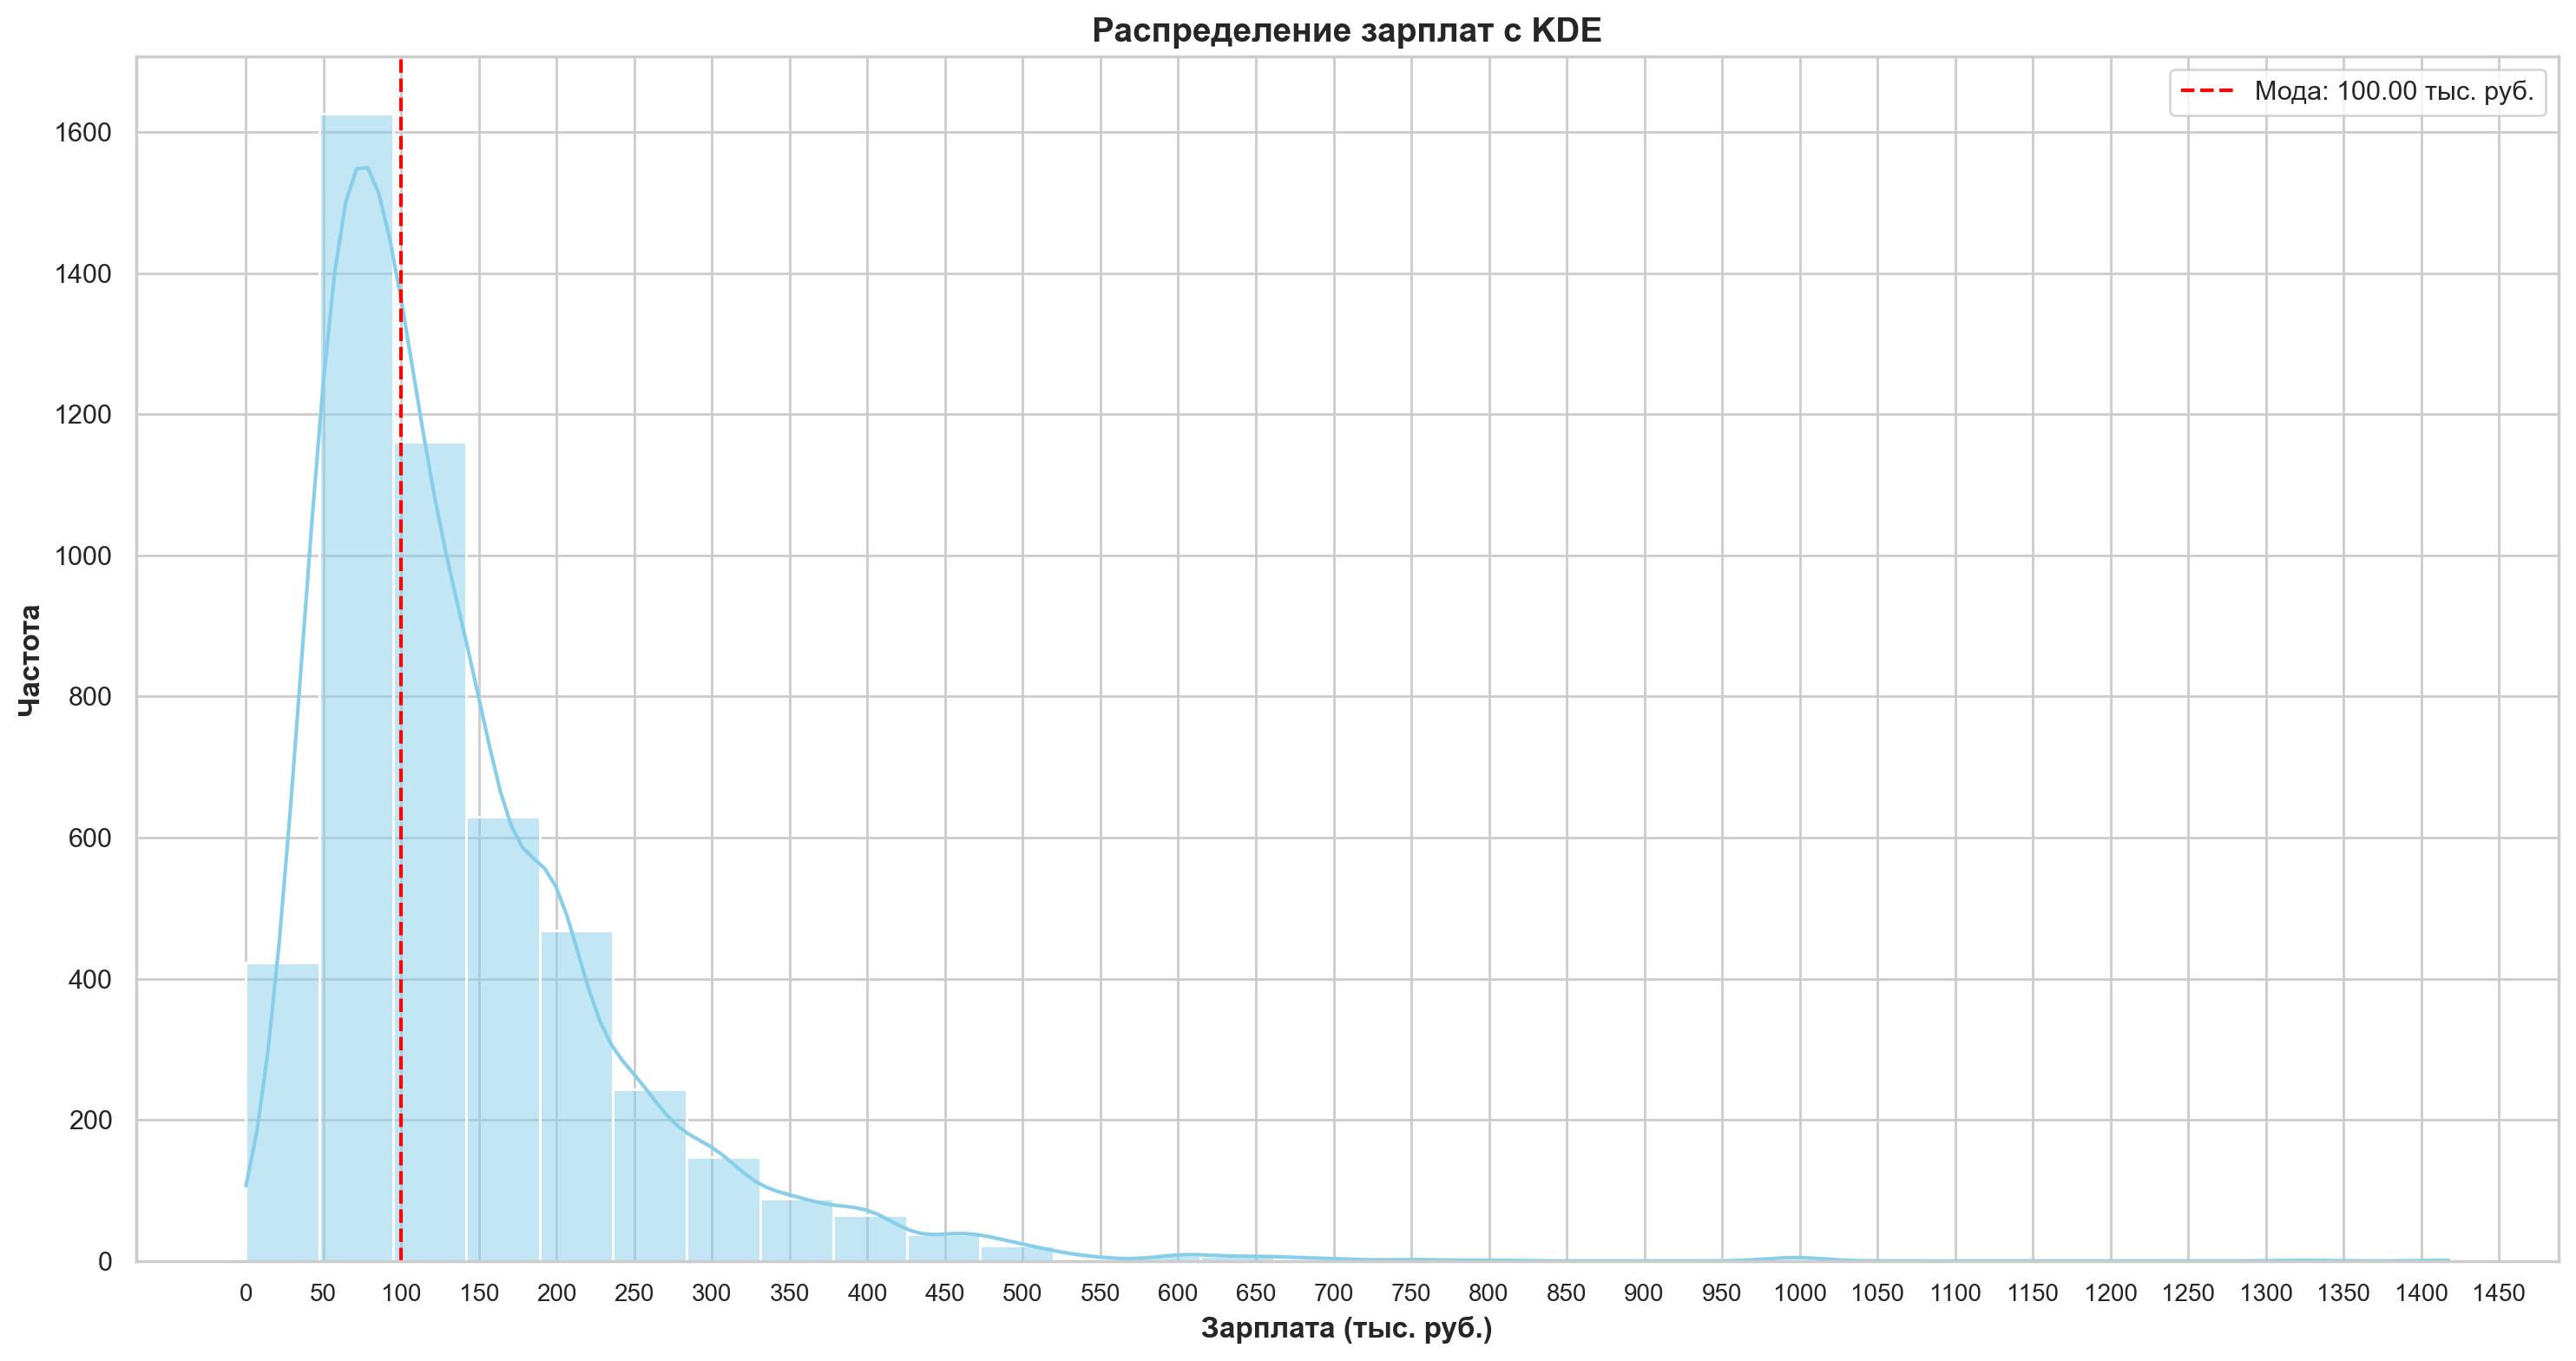

In [42]:
# ДО ОБРАБОТКИ ВЫБРОСОВ

# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(15, 8), dpi=200)  # Увеличим размер фигуры и разрешение

# Вычисляем моду
mode_salary = analysis_df['salary_rub'].mode()[0]

# Построение histplot с KDE для распределения зарплат
sns.histplot(analysis_df['salary_rub'], kde=True, color='skyblue', bins=30)

# Изменяем ось X, чтобы отображать значения в тысячах
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.title('Распределение зарплат с KDE', fontsize=14, weight='bold')

# Добавляем линию моды на график
plt.axvline(mode_salary, color='red', linestyle='--', label=f'Мода: {mode_salary / 1000:.2f} тыс. руб.')

# Показываем легенду
plt.legend()

# Настроим ось X, шаг 50 тыс.
xticks = np.arange(0, analysis_df['salary_rub'].max() + 50000, step=50000)  # Шаг 50 тыс.
plt.xticks(xticks, labels=[f'{int(x/1000)}' for x in xticks], fontsize=10)  # Без "тыс. руб." в метках

plt.tight_layout()
plt.show()

D:\programs\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


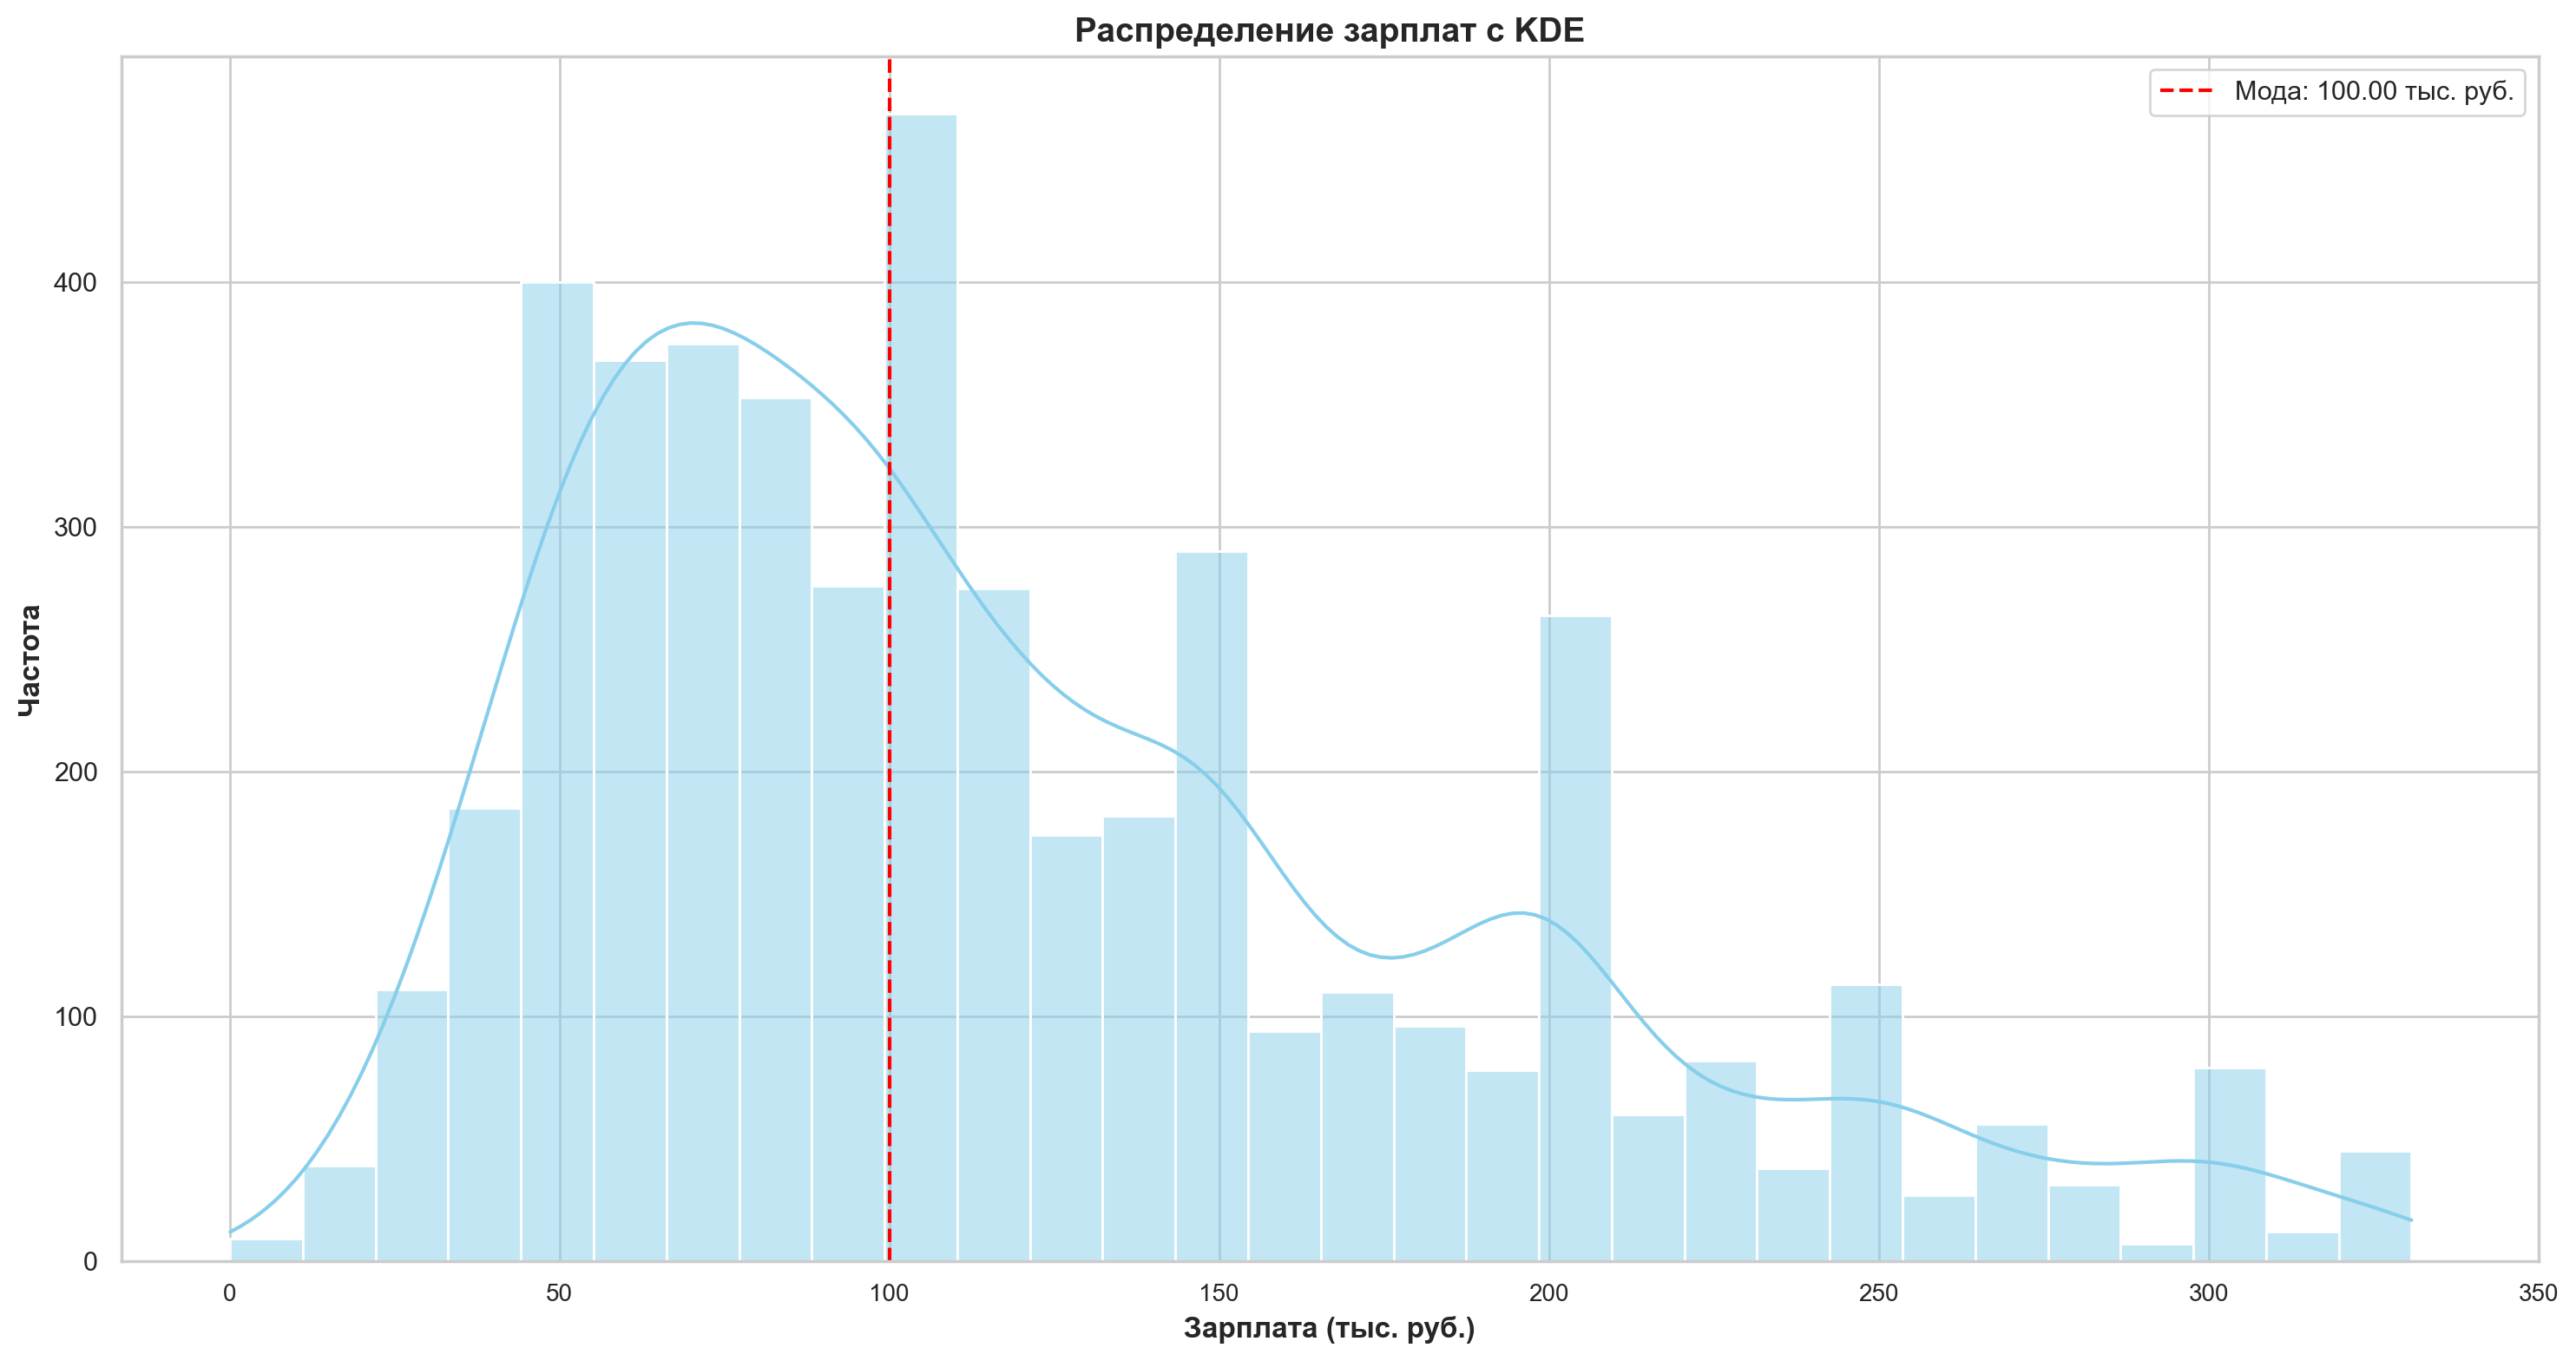

In [43]:
# ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ

# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(15, 8), dpi=200)  # Увеличим размер фигуры и разрешение

# Вычисляем моду
mode_salary = filtered_data['salary_rub'].mode()[0]

# Построение histplot с KDE для распределения зарплат
sns.histplot(filtered_data['salary_rub'], kde=True, color='skyblue', bins=30)

# Изменяем ось X, чтобы отображать значения в тысячах
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.title('Распределение зарплат с KDE', fontsize=14, weight='bold')

# Добавляем линию моды на график
plt.axvline(mode_salary, color='red', linestyle='--', label=f'Мода: {mode_salary / 1000:.2f} тыс. руб.')

# Показываем легенду
plt.legend()

# Настроим ось X, шаг 50 тыс.
xticks = np.arange(0, filtered_data['salary_rub'].max() + 50000, step=50000)  # Шаг 50 тыс.
plt.xticks(xticks, labels=[f'{int(x/1000)}' for x in xticks], fontsize=10)  # Без "тыс. руб." в метках

plt.tight_layout()
plt.show()

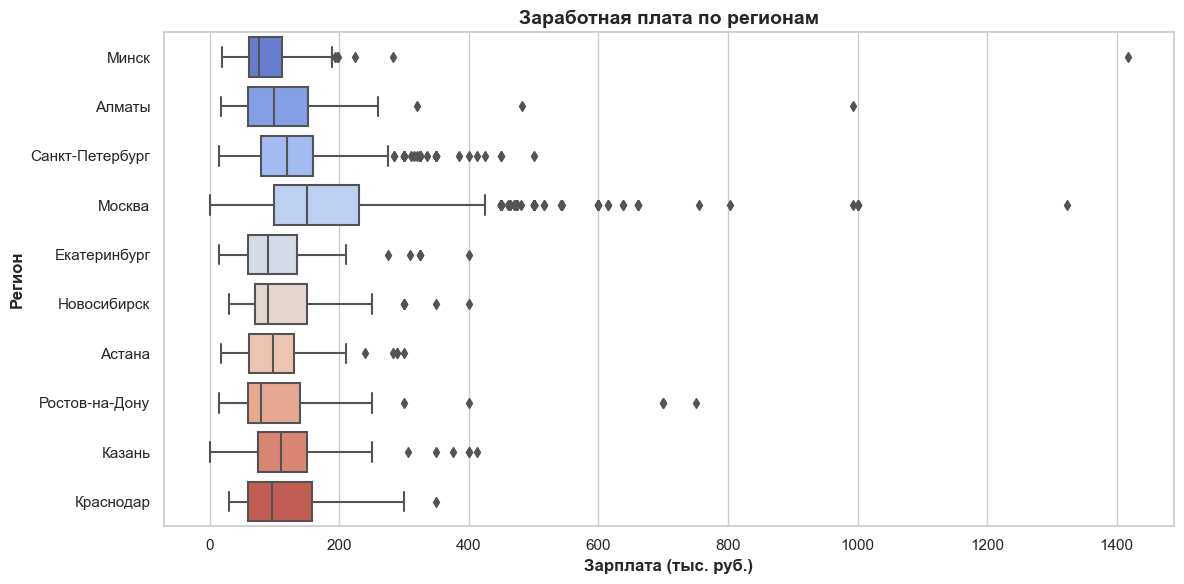

In [49]:
# ДО ОБРАБОТКИ ВЫБРОСОВ

# Преобразуем зарплату внутри DataFrame для региона 'Минск', если зарплата меньше 1000
analysis_df.loc[(analysis_df['area'] == 'Минск') & (analysis_df['salary_rub'] < 1000), 'salary_rub'] *= 1000
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Сформируем топ-10 регионов
top_10_area = analysis_df[analysis_df['area'].isin(['Москва', 'Санкт-Петербург', 'Екатеринбург', 'Казань', 'Алматы', 
                                                     'Ростов-на-Дону', 'Новосибирск', 'Минск', 'Краснодар', 'Астана'])]

# Используем .loc для изменения значения в столбце
top_10_area.loc[:, 'salary_rub'] = top_10_area['salary_rub'] / 1000  # Преобразуем зарплату в тысячи

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(data=top_10_area, y='area', x='salary_rub', palette='coolwarm')  # Добавим палитру цвета для улучшения визуализации

# Настроим подписки осей и заголовок
plt.ylabel('Регион', fontsize=12, weight='bold')
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.title('Заработная плата по регионам', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

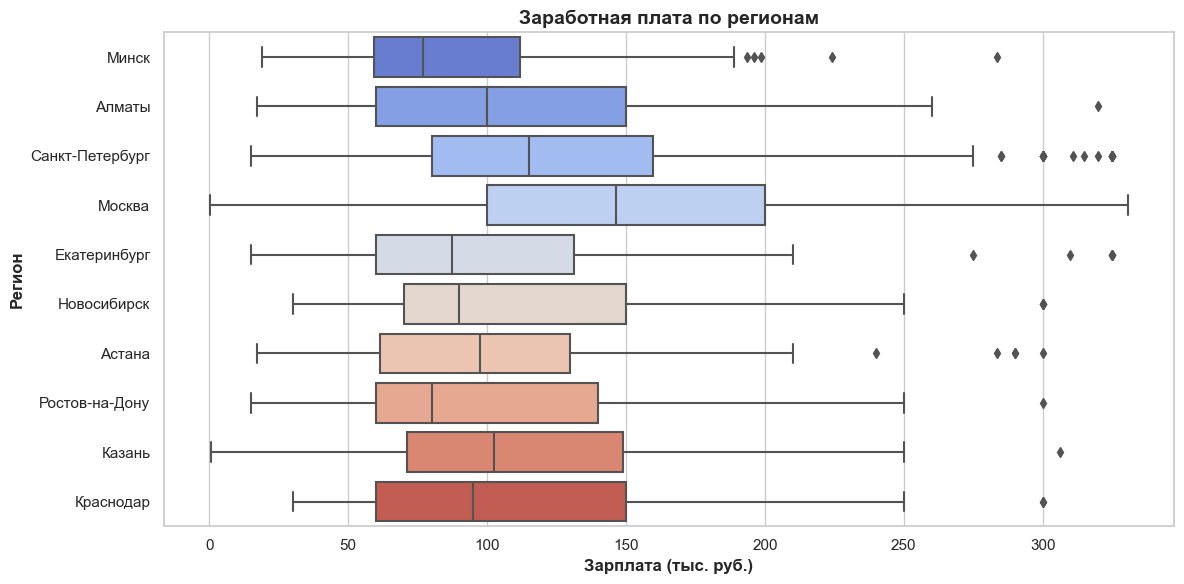

In [50]:
# ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ

# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Сформируем топ-10 регионов
top_10_area = filtered_data[filtered_data['area'].isin(['Москва', 'Санкт-Петербург', 'Екатеринбург', 'Казань', 'Алматы', 
                                                     'Ростов-на-Дону', 'Новосибирск', 'Минск', 'Краснодар', 'Астана'])]

# Используем .loc для изменения значения в столбце
top_10_area.loc[:, 'salary_rub'] = top_10_area['salary_rub'] / 1000  # Преобразуем зарплату в тысячи

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(data=top_10_area, y='area', x='salary_rub', palette='coolwarm')  # Добавим палитру цвета для улучшения визуализации

# Настроим подписки осей и заголовок
plt.ylabel('Регион', fontsize=12, weight='bold')
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.title('Заработная плата по регионам', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

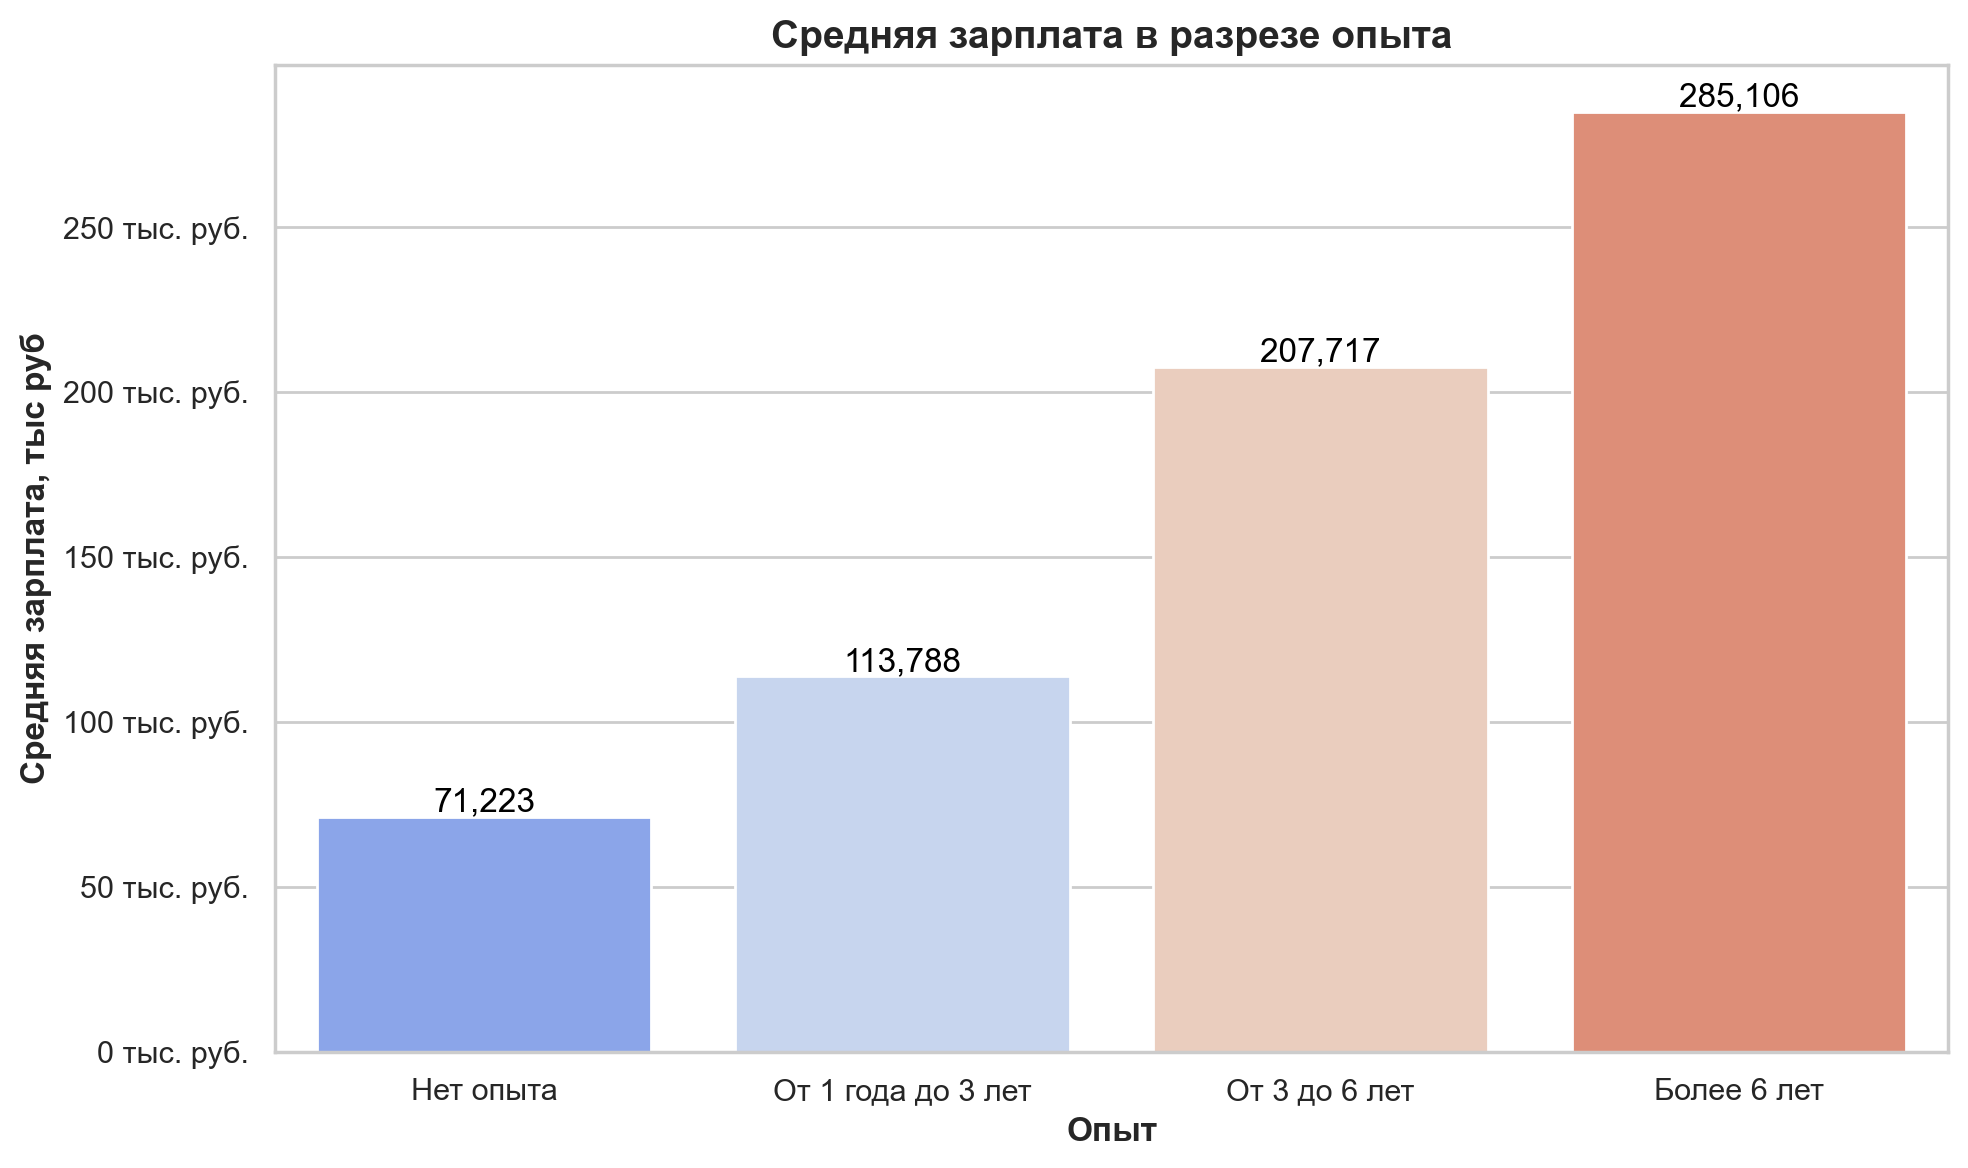

In [51]:
# График зависимости средней зарплаты от опыта работы
experience_salary = analysis_df.groupby('experience')['salary_rub'].mean().round().reset_index(name='mean_salary').sort_values(by='mean_salary')

# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(10, 6), dpi=200)  # Увеличим размер фигуры и разрешение
ax = sns.barplot(data=experience_salary, x='experience', y='mean_salary', palette='coolwarm')  # Добавим пастельные оттенки для столбцов

# Добавление значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Форматирование оси Y
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
ax.yaxis.set_major_formatter(formatter)

# Подписи и заголовок
plt.xlabel('Опыт', fontsize=12, weight='bold')
plt.ylabel('Средняя зарплата, тыс руб', fontsize=12, weight='bold')
plt.title('Средняя зарплата в разрезе опыта', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

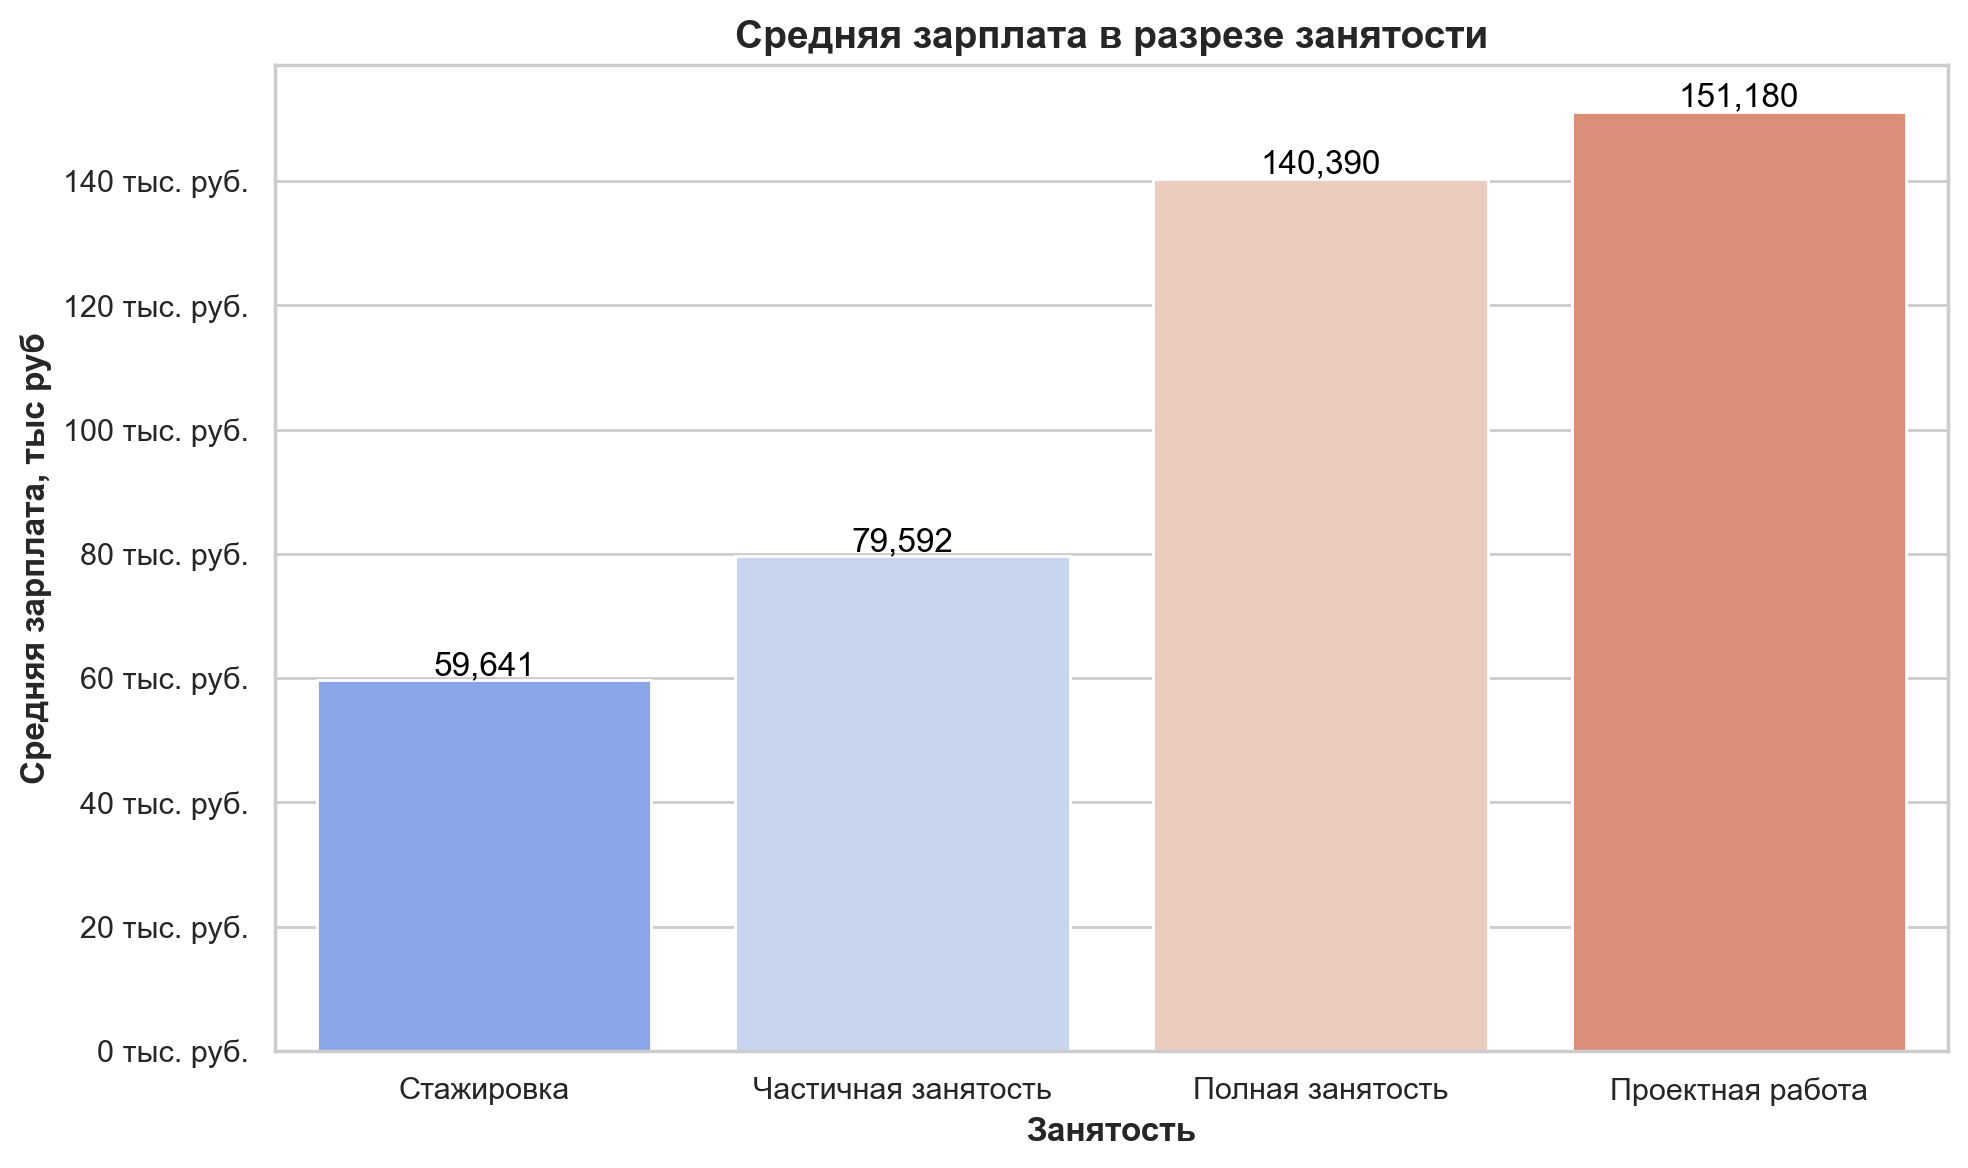

In [53]:
# График средней зарплаты в разрезе занятости
employment_salary =analysis_df.groupby('employment')['salary_rub'].mean().round().reset_index(name='mean_salary').sort_values(by='mean_salary')

# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(10, 6), dpi=200)  # Увеличим размер фигуры и разрешение
ax = sns.barplot(data=employment_salary, x='employment', y='mean_salary', palette='coolwarm')  # Используем палитру 'coolwarm' для столбцов

# Добавление значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Форматирование оси Y
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
ax.yaxis.set_major_formatter(formatter)

# Подписи и заголовок
plt.xlabel('Занятость', fontsize=12, weight='bold')
plt.ylabel('Средняя зарплата, тыс руб', fontsize=12, weight='bold')
plt.title('Средняя зарплата в разрезе занятости', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()